# Load Data

In [1]:
import pickle
import pandas as pd
import plotly.express as px

In [3]:
 with open('../data/processed/adj_mat.dat', 'rb')  as f:
    adj_mat = pickle.load(f)

with open('../data/processed/adj_mat_ind_station_mapper.dat', 'rb') as f:
    ind_station_mapper = pickle.load(f)

with open('../data/processed/speeds.dat', 'rb')  as f:
    speed_df = pickle.load(f)

**Get Time Series for Station with Most Data**

In [18]:
station_speed = speed_df[speed_df.apply(lambda x: x.isna().sum()).idxmin()]
station_speed = station_speed.fillna(method='ffill') # ffill since only 2 missing values. we could also drop these
station_speed = station_speed[station_speed.index.month == 6] # subset and choose data in june
station_speed

2021-06-01 00:00:00    72.8
2021-06-01 00:05:00    72.9
2021-06-01 00:10:00    73.5
2021-06-01 00:15:00    72.4
2021-06-01 00:20:00    72.2
                       ... 
2021-06-30 23:35:00    67.8
2021-06-30 23:40:00    68.0
2021-06-30 23:45:00    69.1
2021-06-30 23:50:00    69.8
2021-06-30 23:55:00    71.0
Name: 716331, Length: 8640, dtype: float64

In [86]:
fig = px.line(x=station_speed.index, y=station_speed, title='Time Series Plot')
fig.update_xaxes(title='Time')
fig.update_yaxes(title='Speed (mph)')

We clearly see seasonality the same time each day during night time. We will remove this by taking the difference of the 288 (daily) lag.

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [92]:
station_speed_no_seasonal = (station_speed - station_speed.shift(288)).dropna()
fig = px.line(x=station_speed_no_seasonal.index, y=station_speed_no_seasonal, title='Time Series Plot w/ Seasonal Component Remvoed')
fig.update_xaxes(title='Time Difference')
fig.update_yaxes(title='Speed (mph)')

**Test if Time Series is Stationary**

$H_0:$ The time series is non-stationary.
<br>
$H_1:$ The time series is stationary.

In [93]:
from statsmodels.tsa.stattools import adfuller

In [94]:
test_stat, p, _, _ , _, _ = adfuller(station_speed_no_seasonal)
p

1.377470245285494e-26

We can conclude the time series is stationary.

**Autocorrelation**

In [100]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [109]:
station_speed_first_diff = (station_speed - station_speed.shift(1)).dropna()

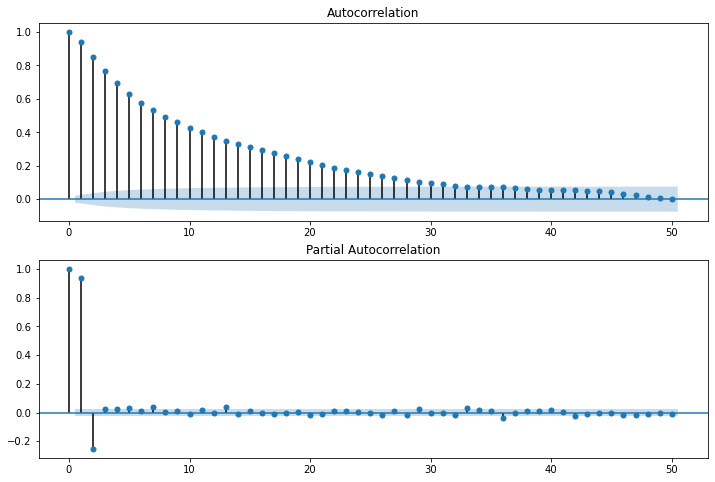

In [112]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(station_speed_no_seasonal,lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(station_speed_no_seasonal,lags=50,ax=ax2)